# Introduction

We saw previously how to create a pair public/secret key for encryption/decryption. Those key are usually very long to ensure that based on the public key, an attacker cannot find the private key. In this Notebook, we will see how this kind of attack can be done and test how fast it can be "cracked" based on the key length.

# Principle

The principle of El Gamal Key Exchange has not been explained previously so you can find bellow an contribution (exercice) I proposed on Codingame:

El Gamal encryption is a public-key cryptosystem. It uses asymmetric key encryption for a safe communication between two people.

Let us assume that Alice wants to communicate with Bob. Alice generates three large random integers:
- Q a prime used as the order of the key
- 0 < G < Q a generator
- X Alice's <b>secret key</b>

Alice computes $ H \equiv G^X \pmod{Q} $ and publicly shares with Bob the public key <b>(G, H, Q)</b>. As an attacker, you intercept this key and decide to spy on their communications. To do so, you need to find Alice's secret key X. This can be done by performing a discrete logarithm attack on this key. 

The rest of this protocol is not explained to avoid overload but it can be found on https://en.wikipedia.org/wiki/ElGamal_encryption

# Attack

There is multiple algorithm existing and we can cite :

### BruteForce

The most basic attack would be the brute force and compute $ G^X \pmod{K} \:\: \forall X \in [A, B]$. However this is very slow as it has a complexity of O(X). The X being so big, there is nearly no chance to break it that way. 

### BabyStep-GiantStep

This algorithm is a most common one because it's quite simple to implement and is a good tradeoff between memory requirement and computation time. You can find a more important description on <a href="https://en.wikipedia.org/wiki/Baby-step_giant-step">Wikipedia</a>.

The complexity if $ O(\sqrt {X}) $ in time and space

### Pollard's rho

This algorithm is older and less efficient that BSGS above. It is derived from al algorithm for the integer factorization problem and uses the same bases. See <a href="https://en.wikipedia.org/wiki/Pollard%27s_rho_algorithm_for_logarithms">Wikipedia</a> for more information.

The complexity if $ O(\sqrt {X}) $ in time. The complexity in term of space if nearly null

### Pohlig–Hellman

This last algorithm should be the fastest. It is in average in $ O(\log({X})) $ and worst case $ O(\sqrt {X}) $. It's also the most recent one (but also the most complex one :) ). More details on <a href="https://en.wikipedia.org/wiki/Pohlig%E2%80%93Hellman_algorithm">Wikipedia</a>

# Exercice

For this Notebook, we will implement the BSGS and run it on multiple keys of different length to see how the speed to solve it evolves

### Generate keys

In [1]:
from math import gcd, ceil, sqrt
import random
import matplotlib.pyplot as plt
import time
from random import randrange, getrandbits
from sklearn.linear_model import LinearRegression
import numpy as np


def egcd(number, modulo):
    if number == 0:
        return modulo, 0, 1
    else:
        g, y, x = egcd(modulo % number, number)
        return g, x - (modulo // number) * y, y

def modinv(number, modulo):
    g, x, y = egcd(number, modulo)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % modulo
    
def is_prime(n, k=128):
    """ Test if a number is prime
        Args:
            n -- int -- the number to test
            k -- int -- the number of tests to do
        return True if n is prime
    """
    # Test if n is not even.
    # But care, 2 is prime !
    if n == 2 or n == 3:
        return True
    if n <= 1 or n % 2 == 0:
        return False
    # find r and s
    s = 0
    r = n - 1
    while r & 1 == 0:
        s += 1
        r //= 2
    # do k tests
    for _ in range(k):
        a = randrange(2, n - 1)
        x = pow(a, r, n)
        if x != 1 and x != n - 1:
            j = 1
            while j < s and x != n - 1:
                x = pow(x, 2, n)
                if x == 1:
                    return False
                j += 1
            if x != n - 1:
                return False
    return True

def generate_prime_candidate(length):
    """ Generate an odd integer randomly
        Args:
            length -- int -- the length of the number to generate, in bits
        return a integer
    """
    # generate random bits
    p = getrandbits(length)
    # apply a mask to set MSB and LSB to 1
    p |= (1 << length - 1) | 1
    return p

def generate_prime_number(length=1024):
    """ Generate a prime
        Args:
            length -- int -- length of the prime to generate, in bits
        return a prime
    """
    p = 4
    # keep generating while the primality test fail
    while not is_prime(p, 128):
        p = generate_prime_candidate(length)
    return p

In [2]:
random.seed(0)

public_keys = []
private_keys = []

for key_size in range(10, 40, 2):
    G = int(random.getrandbits(key_size))
    X = int(random.getrandbits(key_size))
    Q = generate_prime_number(key_size+4) # +45 to have Q > G
    H = pow(G, X, Q)
    public_keys.append((G, H, Q))
    private_keys.append(X)

Similarly to a dataset in Data Science, we now have the public key and we have to find the private key. Let's implement the BSGS 

In [55]:
public_keys

[(864, 786, 13597),
 (3479, 43560, 58657),
 (11162, 169379, 238037),
 (23652, 311877, 660227),
 (253912, 1706452, 2961619),
 (811407, 5947378, 14225027),
 (597971, 29503660, 36489829),
 (10276158, 166461018, 201727129),
 (42570930, 258268552, 692774963),
 (151593142, 1303174335, 4108412939),
 (55034527, 6822928810, 11975829493),
 (3646822369, 23499338479, 40701397531),
 (9576791999, 28442392868, 239051167937),
 (28142617842, 60367878968, 863490862849),
 (33515127037, 378237615940, 3256858955599)]

In [56]:
private_keys

[394,
 881,
 6715,
 25873,
 97339,
 163742,
 1490519,
 1453404,
 17514606,
 247365369,
 606523847,
 3452146706,
 1564751905,
 55656656128,
 193988565560]

# Baby-step giant-step algorithm

In [57]:
def bsgs(a, c, P):
    '''
    Solve for x in h = g^x mod p given a prime p.
    If p is not prime, you shouldn't use BSGS anyway.
    '''
    N = ceil(sqrt(P - 1))  # phi(p) is p-1 if p is prime

    # Store hashmap of g^{1...m} (mod p). Baby step.
    memo = {pow(a, i, P): i for i in range(N)}

    # Precompute via Fermat's Little Theorem
    d = pow(a, N * (P - 2), P)     # https://en.wikipedia.org/wiki/Modular_multiplicative_inverse#Using_Euler.27s_theorem

    # Search for an equivalence in the table. Giant step.
    for j in range(N):
        y = (c * pow(d, j, P)) % P
        if y in memo:
            return j * N + memo[y]

    return None

In [58]:
t = []

for key_size, public, private in zip(range(10, 40, 2), public_keys, private_keys):
    print("\nKeys size {}".format(key_size))
    s = time.time()
    ans = bsgs(*public)
    d = time.time() - s
    t.append(d)
    print("Private Key Found : {}".format(ans,))
    print("Real Private Key  : {}".format(private))
    print("Duration : {:03f}".format(d))


Keys size 10
Private Key Found : 394
Real Private Key  : 394
Duration : 0.000998

Keys size 12
Private Key Found : 881
Real Private Key  : 881
Duration : 0.000000

Keys size 14
Private Key Found : 6715
Real Private Key  : 6715
Duration : 0.000998

Keys size 16
Private Key Found : 25873
Real Private Key  : 25873
Duration : 0.000997

Keys size 18
Private Key Found : 97339
Real Private Key  : 97339
Duration : 0.002075

Keys size 20
Private Key Found : 163742
Real Private Key  : 163742
Duration : 0.006928

Keys size 22
Private Key Found : 1490519
Real Private Key  : 1490519
Duration : 0.009948

Keys size 24
Private Key Found : 1453404
Real Private Key  : 1453404
Duration : 0.024908

Keys size 26
Private Key Found : 17514606
Real Private Key  : 17514606
Duration : 0.050891

Keys size 28
Private Key Found : 247365369
Real Private Key  : 247365369
Duration : 0.194781

Keys size 30
Private Key Found : 606523847
Real Private Key  : 606523847
Duration : 0.356621

Keys size 32
Private Key Found 

# Time Analysis

The forward path which is to compute the $ H \equiv G^X \pmod{Q} $ can be considered as instantaneous with the modular multiplication for the length of keys we computed here (up to 40 bits). Just in opposition, current keys are at around 2048 bits. At this level the time is few ms only. Let's have a look at the time to find back the private key and try to find a equation of the time.

<b>Attention : For the following equation, I found out that the complexity seems to be more a log(N) complexity so I computed the prediction of the time based on this assumption</b>

In [70]:
x = [[len(bin(z))-2] for x, y, z in public_keys]  # get the size of the Q for each keys
y = np.log(np.array(t)+1e-5).reshape(-1, 1)

In [71]:
regr = LinearRegression()
regr.fit(x, y)
print(regr.coef_, regr.intercept_)

[[0.40640678]] [-14.95194245]


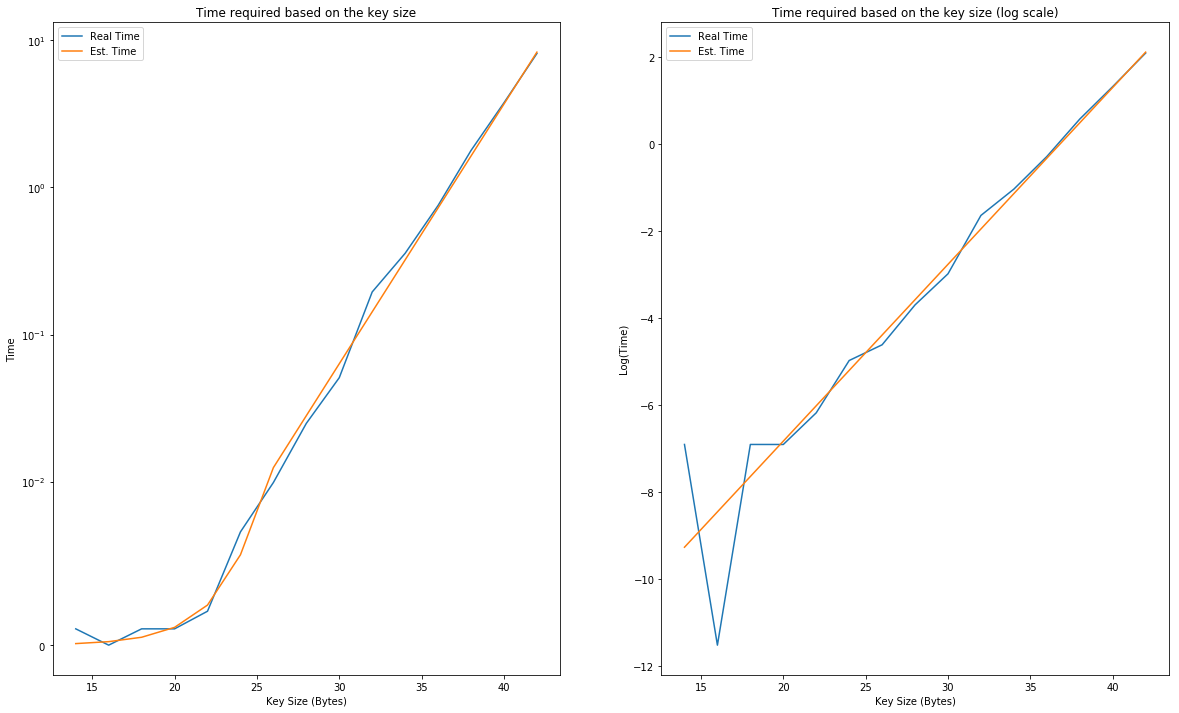

In [81]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 12))
ax.plot(x, t, label ="Real Time")
ax.plot(x, np.exp(regr.predict(x)), label ="Est. Time")
ax.set_yscale('symlog', linthreshy=0.01)
ax.set_title("Time required based on the key size")
ax.set_ylabel("Time")
ax.set_xlabel("Key Size (Bytes)")
ax.legend()

ax2.plot(x, y, label ="Real Time")
ax2.plot(x, regr.predict(x), label ="Est. Time")
ax2.set_title("Time required based on the key size (log scale)")
ax2.set_ylabel("Log(Time)")
ax2.set_xlabel("Key Size (Bytes)")
ax2.legend()

plt.show()

now we know how the time will evolve, let's compute the time to break a 1024 bit key with this algo (knowing that we nearly never use a 1024 bit key anymore)

In [113]:
np.exp(regr.predict(1024)) / (365*24*3600)

array([[5.54464963e+166]])

This would means $ 5^{166} $ years !!! Even if the code is written in a more efficient way and shared in multiple computer/cores, the time will not be reachable with the current computation power. To this, we have also to consider memory. This is more difficult to estimate but the dictionnary (memo) will probably not fit into memory too !

# Conclusion

In this Notebook, I wanted to learn a bit more avoir Discrete Log Attack. Unfortunately, I was not able to make Pollard's rho and Pohlig–Hellman algorithms working. There is few implementations on github but not always working (For example Pollard's rho was a lot faster than BSGS by far but was not finding all private keys properly - it got only 3 keys correct). 

We saw that the time to get the private key from the public key increase quickly and this is why the key has to be big.  For sure the BSGS is not effichient enough quickly but the first tries of Pollard's roh solve the 38 bits key in 0.2 seconds (vs 8s for BSGS) so maybe a working implementation could solve a lot bigger key.

Finally, to implement real good solution for this kind of attacks, another language will be more than required to have the best performances as possible. That'es why C++ implementation is a lot more common.